In [1]:
%matplotlib inline
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import numpy as np
from pathlib import Path
import tensorflow as tf
import os
from PIL import Image, ImageDraw
from IPython.display import HTML

In [2]:
# Define bucket and blob prefix

model_bucket_name = 'cat-detection-models'
photo_bucket_name = 'catflap-photos-raw'
dates = ['2020-06-14']

In [3]:
# Set up buckets

client = storage.Client()
model_bucket = client.get_bucket(model_bucket_name)
photo_bucket = client.get_bucket(photo_bucket_name)

# Read predictions produced by batch prediction

In [4]:
# Get list of blob names

blob_list = []
for date in dates:
    blobs = model_bucket.list_blobs(prefix=f'batch-output-keys/{date}')
    blob_date_list = [blob.name for blob in blobs]
    blob_list += blob_date_list
blob_list

['batch-output-keys/2020-06-14_08/prediction.errors_stats-00000-of-00001',
 'batch-output-keys/2020-06-14_08/prediction.results-00000-of-00001',
 'batch-output-keys/2020-06-14_09/prediction.errors_stats-00000-of-00001',
 'batch-output-keys/2020-06-14_09/prediction.results-00000-of-00001',
 'batch-output-keys/2020-06-14_10/prediction.errors_stats-00000-of-00001',
 'batch-output-keys/2020-06-14_10/prediction.results-00000-of-00001']

In [5]:
# Filter blob list to remove errors and leave results

result_list = [x for x in blob_list if 'results' in x]
result_list

['batch-output-keys/2020-06-14_08/prediction.results-00000-of-00001',
 'batch-output-keys/2020-06-14_09/prediction.results-00000-of-00001',
 'batch-output-keys/2020-06-14_10/prediction.results-00000-of-00001']

In [6]:
# Read predictions into pandas dataframe

df_list = []
for blob in blob_list:
    labels = pd.read_json('gs://'+model_bucket_name+'/'+blob, lines=True)
    df_list += [labels]
prediction_df = pd.concat(df_list, ignore_index=True, sort=False)

print(prediction_df.shape)
prediction_df.head()

(1468, 2)


,babyweight,key
0,"[165.26763916015625, -65.74021911621094]",2020-06-14_080030.jpg
1,"[155.4508056640625, -62.90538787841797]",2020-06-14_080039.jpg
2,"[173.4664306640625, -71.03665161132812]",2020-06-14_080046.jpg
3,"[154.16542053222656, -64.751953125]",2020-06-14_080053.jpg
4,"[163.10421752929688, -66.78430938720703]",2020-06-14_080100.jpg


In [7]:
# Extract prediction

prediction_df['prediction'] = prediction_df.babyweight.apply(np.argmax)

prediction_df.head()

,babyweight,key,prediction
0,"[165.26763916015625, -65.74021911621094]",2020-06-14_080030.jpg,0
1,"[155.4508056640625, -62.90538787841797]",2020-06-14_080039.jpg,0
2,"[173.4664306640625, -71.03665161132812]",2020-06-14_080046.jpg,0
3,"[154.16542053222656, -64.751953125]",2020-06-14_080053.jpg,0
4,"[163.10421752929688, -66.78430938720703]",2020-06-14_080100.jpg,0


In [8]:
prediction_df.prediction.value_counts()

0    1423
1      45
Name: prediction, dtype: int64

# Analyse predictions

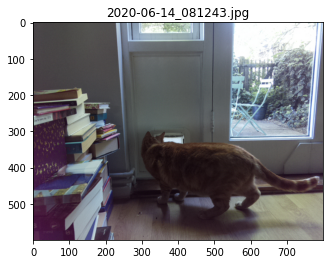

In [9]:
# Plot true positives

for blob_name in prediction_df[prediction_df.prediction==1].key:
    
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break

In [10]:
# Create GIF of true positives

train_images = []
for blob_name in prediction_df[prediction_df.prediction==1].key:
    blob = photo_bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = Image.open(bytes_io)
    img_resize = img.resize((80*4,60*4))
    
    # Add key text
    draw = ImageDraw.Draw(img_resize)
    draw.text((0, 0),blob_name,(255,255,255))
    
    train_images += [img_resize]
gif_filename = 'detections.gif'
train_images[0].save(gif_filename, save_all=True, append_images=train_images[1:], optimize=True, duration=100, loop=0, dpi=(80,60))

HTML(f'<img src="{gif_filename}">')